### Methodology

In [24]:
xgb.__version__

'1.4.2'

In [25]:
!pip install xgboost==1.4.2

You should consider upgrading via the 'c:\users\jazi designs\anaconda3\python.exe -m pip install --upgrade pip' command.


### Import Libraries

In [26]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE
import xgboost as xgb

### Import Datasets

In [27]:
# Import logs data
logs = pd.read_csv("logs.csv")
logs.head()

,evse_id,status,last_updated
0,EVSE_01,AVAILABLE,2022-03-01 00:00:00+00:00
1,EVSE_02,OUTOFORDER,2022-03-01 00:00:00+00:00
2,EVSE_03,UNKNOWN,2022-03-01 00:00:00+00:00
3,EVSE_04,CHARGING,2022-03-01 00:00:00+00:00
4,EVSE_05,OUTOFORDER,2022-03-01 01:55:30.783000+00:00


In [28]:
# Import metadata data
metadata = pd.read_csv("metadata.csv")
metadata.head()

,latitude,longitude,twentyfourseven,capabilities,power_type,format,amperage,voltage,power_kw,evse_id,location_id
0,42.032139,50.535391,True,"RFID_READER,REMOTE_START_STOP_CAPABLE",AC_3_PHASE,SOCKET,16.0,230.0,22.0,EVSE_20,LOC_01
1,42.032139,50.535391,True,"RFID_READER,REMOTE_START_STOP_CAPABLE",AC_3_PHASE,SOCKET,16.0,230.0,22.0,EVSE_36,LOC_01
2,41.942522,50.585466,True,"RFID_READER,RFID_READER,REMOTE_START_STOP_CAPA...",AC_3_PHASE,SOCKET,32.0,230.0,22.0,EVSE_72,LOC_02
3,41.942522,50.585466,True,"RFID_READER,RFID_READER,REMOTE_START_STOP_CAPA...",AC_3_PHASE,SOCKET,32.0,230.0,22.0,EVSE_22,LOC_02
4,42.035796,50.505329,True,"RFID_READER,RFID_READER,REMOTE_START_STOP_CAPA...",AC_3_PHASE,SOCKET,32.0,230.0,22.0,EVSE_76,LOC_03


In [29]:
# Combine daatsets
data = pd.merge(metadata, logs, on = "evse_id")
data.head()

,latitude,longitude,twentyfourseven,capabilities,power_type,format,amperage,voltage,power_kw,evse_id,location_id,status,last_updated
0,42.032139,50.535391,True,"RFID_READER,REMOTE_START_STOP_CAPABLE",AC_3_PHASE,SOCKET,16.0,230.0,22.0,EVSE_20,LOC_01,UNKNOWN,2022-03-01 07:47:57.605000+00:00
1,42.032139,50.535391,True,"RFID_READER,REMOTE_START_STOP_CAPABLE",AC_3_PHASE,SOCKET,16.0,230.0,22.0,EVSE_20,LOC_01,CHARGING,2022-03-01 08:47:25.307000+00:00
2,42.032139,50.535391,True,"RFID_READER,REMOTE_START_STOP_CAPABLE",AC_3_PHASE,SOCKET,16.0,230.0,22.0,EVSE_20,LOC_01,UNKNOWN,2022-03-01 17:47:42.027000+00:00
3,42.032139,50.535391,True,"RFID_READER,REMOTE_START_STOP_CAPABLE",AC_3_PHASE,SOCKET,16.0,230.0,22.0,EVSE_20,LOC_01,AVAILABLE,2022-03-02 04:02:35.096000+00:00
4,42.032139,50.535391,True,"RFID_READER,REMOTE_START_STOP_CAPABLE",AC_3_PHASE,SOCKET,16.0,230.0,22.0,EVSE_20,LOC_01,UNKNOWN,2022-03-02 11:47:53.491000+00:00


In [30]:
# Data Information
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10565 entries, 0 to 10564
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   latitude         10565 non-null  float64
 1   longitude        10565 non-null  float64
 2   twentyfourseven  10565 non-null  bool   
 3   capabilities     10565 non-null  object 
 4   power_type       10565 non-null  object 
 5   format           10565 non-null  object 
 6   amperage         10565 non-null  float64
 7   voltage          10565 non-null  float64
 8   power_kw         10565 non-null  float64
 9   evse_id          10565 non-null  object 
 10  location_id      10565 non-null  object 
 11  status           10565 non-null  object 
 12  last_updated     10565 non-null  object 
dtypes: bool(1), float64(5), object(7)
memory usage: 1.1+ MB


In [31]:
# Data Statistics
data.describe()

,latitude,longitude,amperage,voltage,power_kw
count,10565.000000,10565.000000,10565.000000,10565.000000,10565.000000
mean,42.015396,50.551076,62.978325,286.625651,38.676763
std,0.035891,0.037452,86.823569,130.503316,55.187786
min,41.926737,50.485521,16.000000,230.000000,11.000000
25%,42.005324,50.526600,32.000000,230.000000,22.000000
50%,42.023096,50.543822,32.000000,230.000000,22.000000
75%,42.033775,50.575732,32.000000,230.000000,22.000000
max,42.095638,50.635083,400.000000,875.000000,350.000000


### Data Prepocessing and Cleaning

In [32]:
# Drop irrelevant columns
df = data.drop(columns = ["latitude", "longitude", "twentyfourseven", "evse_id", "last_updated"])
df.head()

,capabilities,power_type,format,amperage,voltage,power_kw,location_id,status
0,"RFID_READER,REMOTE_START_STOP_CAPABLE",AC_3_PHASE,SOCKET,16.0,230.0,22.0,LOC_01,UNKNOWN
1,"RFID_READER,REMOTE_START_STOP_CAPABLE",AC_3_PHASE,SOCKET,16.0,230.0,22.0,LOC_01,CHARGING
2,"RFID_READER,REMOTE_START_STOP_CAPABLE",AC_3_PHASE,SOCKET,16.0,230.0,22.0,LOC_01,UNKNOWN
3,"RFID_READER,REMOTE_START_STOP_CAPABLE",AC_3_PHASE,SOCKET,16.0,230.0,22.0,LOC_01,AVAILABLE
4,"RFID_READER,REMOTE_START_STOP_CAPABLE",AC_3_PHASE,SOCKET,16.0,230.0,22.0,LOC_01,UNKNOWN


**Separate Features and Target**

In [33]:
X = df[df.columns.drop("status")]
y = df["status"]

**Apply one hot encoding**

In [34]:
X = pd.get_dummies(X, drop_first = True)
X.head()

,amperage,voltage,power_kw,"capabilities_RFID_READER,REMOTE_START_STOP_CAPABLE","capabilities_RFID_READER,REMOTE_START_STOP_CAPABLE,CREDIT_CARD_PAYABLE","capabilities_RFID_READER,RFID_READER,REMOTE_START_STOP_CAPABLE","capabilities_RFID_READER,RFID_READER,REMOTE_START_STOP_CAPABLE,CREDIT_CARD_PAYABLE",power_type_DC,format_SOCKET,location_id_LOC_02,...,location_id_LOC_42,location_id_LOC_43,location_id_LOC_44,location_id_LOC_45,location_id_LOC_46,location_id_LOC_47,location_id_LOC_48,location_id_LOC_49,location_id_LOC_50,location_id_LOC_51
0,16.0,230.0,22.0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,16.0,230.0,22.0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,16.0,230.0,22.0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,16.0,230.0,22.0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,16.0,230.0,22.0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


**Features Importance**

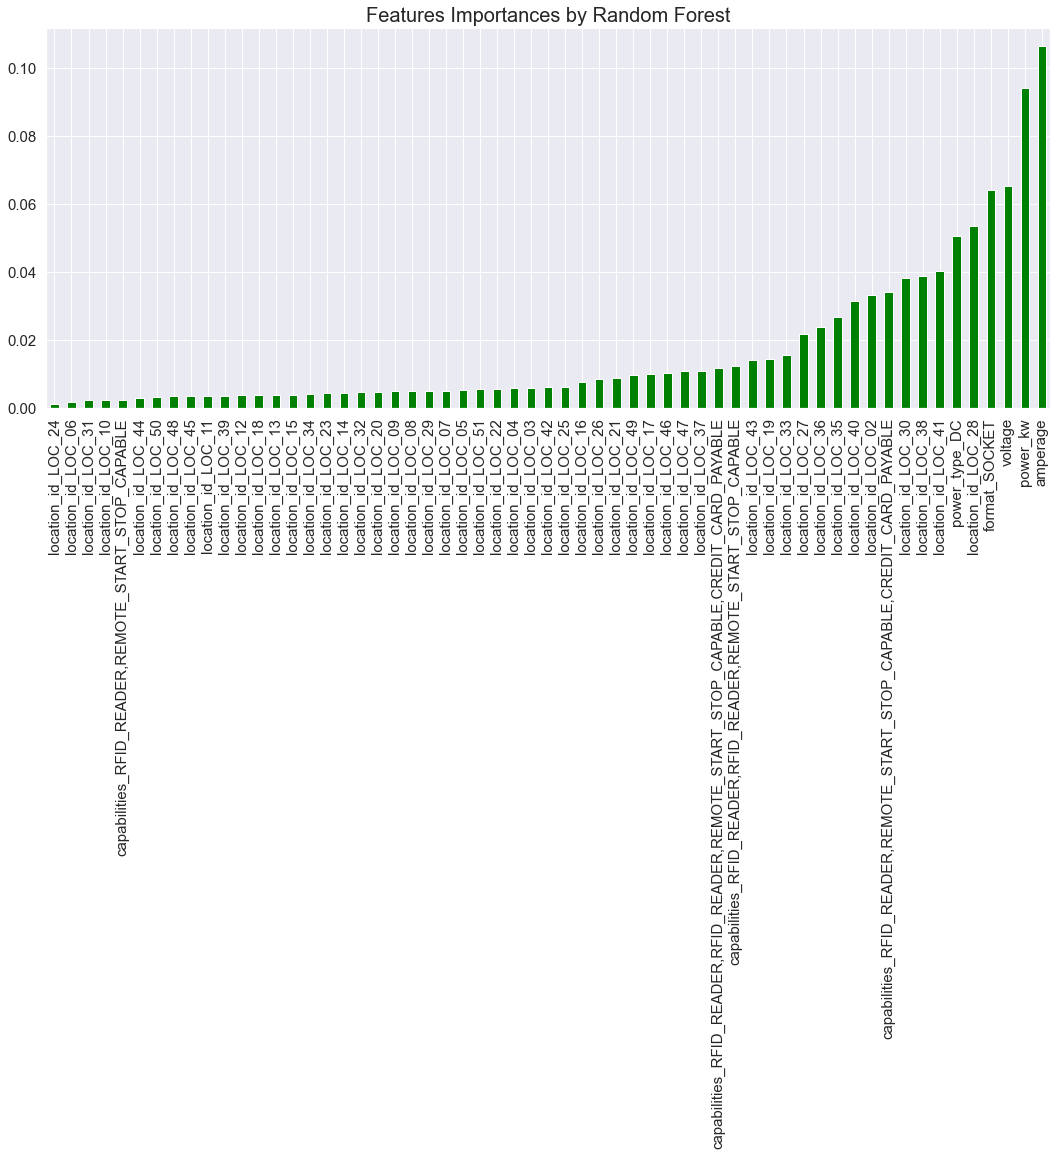

In [35]:
rf=RandomForestClassifier()
rf.fit(X, y)
imp = pd.Series(data = rf.feature_importances_, index = X.columns)
imp_sorted = imp.sort_values()
imp_sorted.plot(kind = "bar", color = "green", figsize = (18, 7))
plt.title("Features Importances by Random Forest", size = 20)
plt.yticks(size = 15)
plt.xticks(size = 15, rotation = 90)
plt.savefig("Feature_Importance.png")
plt.show()

**Select the best three parameters with respect to importance**

In [36]:
X = X[["amperage", "voltage", "power_kw"]]
y = df["status"]

**Correlation among features**

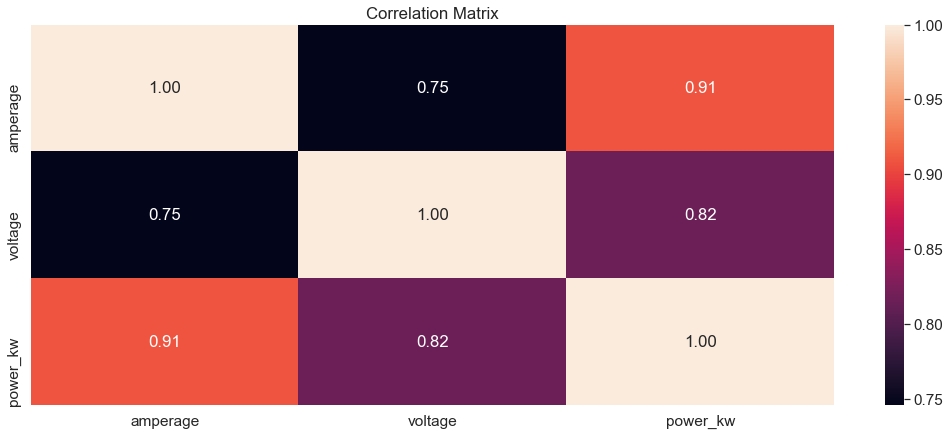

In [37]:
sns.set(font_scale=1.4)
plt.figure(figsize=(18, 7))
correlation=X.corr()
sns.heatmap(correlation, annot = True, fmt = ".2f")
plt.title("Correlation Matrix")
plt.savefig("Correlation.png")
plt.show()

### Model Buiilding

**Split data into training set and testing set**

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    stratify = y,
                                                    random_state = 1111)

**Apply smote to balance the classes**

In [39]:
sm = SMOTE(random_state=0)
X_train, y_train = sm.fit_resample(X_train, y_train)

### Decision Tree 

**Grid Search CV**

In [275]:
params = {"max_depth": np.arange(1, 50)}

dt = DecisionTreeClassifier(criterion = "gini", random_state = 12)

cv_dt = GridSearchCV(dt, params)

cv_dt.fit(X_train, y_train)

cv_dt.best_params_

{'max_depth': 3}

In [276]:
cv_dt.best_score_

0.3186235886723797

In [277]:
dtr = DecisionTreeClassifier(max_depth = 3, random_state = 12)

dtr.fit(X_train, y_train)

pred_dtr = dtr.predict(X_test)

pd.DataFrame({"Actual": y_test, "Predicted": pred_dtr}).head(5)

,Actual,Predicted
341,OUTOFORDER,UNKNOWN
10178,AVAILABLE,AVAILABLE
9637,CHARGING,CHARGING
6757,AVAILABLE,UNKNOWN
9942,CHARGING,UNKNOWN


**Confusion Matrix**

In [278]:
pd.DataFrame(confusion_matrix(y_test, pred_dtr))

,0,1,2,3
0,300,43,12,900
1,296,23,10,918
2,22,0,3,262
3,0,0,0,381


**Classification Report**

In [279]:
print(classification_report(y_test, pred_dtr))

              precision    recall  f1-score   support

   AVAILABLE       0.49      0.24      0.32      1255
    CHARGING       0.35      0.02      0.04      1247
  OUTOFORDER       0.12      0.01      0.02       287
     UNKNOWN       0.15      1.00      0.27       381

    accuracy                           0.22      3170
   macro avg       0.28      0.32      0.16      3170
weighted avg       0.36      0.22      0.17      3170



### Random Forest Classifier

**Use Grid Search Cross Validation** 

In [280]:
params = {"max_depth": np.arange(1, 20),
          "n_estimators": np.arange(10, 101, 10)}

rf = RandomForestClassifier(criterion = "gini", random_state = 12)

rf_cv = GridSearchCV(rf, params)

rf_cv.fit(X_train, y_train)

rf_cv.best_params_

{'max_depth': 2, 'n_estimators': 90}

**Best Score**

In [281]:
rf_cv.best_score_

0.3186235886723797

**Use random forest with best parameters**

In [282]:
rf = RandomForestClassifier(max_depth = 2, n_estimators = 90, criterion = "gini", random_state = 12)

rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

pd.DataFrame({"Actual": y_test,
              "Predicted": pred_rf}).head(5)

,Actual,Predicted
341,OUTOFORDER,UNKNOWN
10178,AVAILABLE,AVAILABLE
9637,CHARGING,CHARGING
6757,AVAILABLE,UNKNOWN
9942,CHARGING,UNKNOWN


**Classification Report**

In [283]:
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

   AVAILABLE       0.49      0.24      0.32      1255
    CHARGING       0.35      0.02      0.04      1247
  OUTOFORDER       0.12      0.01      0.02       287
     UNKNOWN       0.15      1.00      0.27       381

    accuracy                           0.22      3170
   macro avg       0.28      0.32      0.16      3170
weighted avg       0.36      0.22      0.17      3170



**Confusion Matrix**

In [284]:
pd.DataFrame(confusion_matrix(y_test, pred_rf))

,0,1,2,3
0,300,43,12,900
1,296,23,10,918
2,22,0,3,262
3,0,0,0,381


### XGBoost Classifier

**Label encoding on y_train and y_test**

**XGBoost Model**

In [40]:
xgboost = xgb.XGBClassifier(random_state = 12)

xgboost.fit(X_train, y_train)

pred_xgb = xgboost.predict(X_test)
pd.DataFrame({"Actual": y_test,
              "Predicted": pred_xgb}).sample(5)

[22:13:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Actual,Predicted
7080,UNKNOWN,UNKNOWN
1146,AVAILABLE,UNKNOWN
9261,CHARGING,UNKNOWN
3110,AVAILABLE,UNKNOWN
3503,UNKNOWN,UNKNOWN


**Confusion Matrix for XGBoost**

In [41]:
pd.DataFrame(confusion_matrix(y_test, pred_xgb))

,0,1,2,3
0,300,43,12,900
1,296,23,10,918
2,22,0,3,262
3,0,0,0,381


**Classification Report for XGBoost**

In [42]:
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

   AVAILABLE       0.49      0.24      0.32      1255
    CHARGING       0.35      0.02      0.04      1247
  OUTOFORDER       0.12      0.01      0.02       287
     UNKNOWN       0.15      1.00      0.27       381

    accuracy                           0.22      3170
   macro avg       0.28      0.32      0.16      3170
weighted avg       0.36      0.22      0.17      3170



### Random Forest, Decision Tree and XGBoost have same accuracy

**Statistics by AVAILABLE status**

In [325]:
available_status = data[data["status"] == "AVAILABLE"]
available_status.describe()

,latitude,longitude,amperage,voltage,power_kw
count,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000
mean,42.013575,50.554267,70.842256,300.890296,42.876673
std,0.036633,0.038903,95.526564,142.527062,61.045502
min,41.926737,50.485521,16.000000,230.000000,11.000000
25%,42.002225,50.527464,32.000000,230.000000,22.000000
50%,42.020540,50.546325,32.000000,230.000000,22.000000
75%,42.033639,50.575732,62.000000,230.000000,43.000000
max,42.095638,50.635083,400.000000,875.000000,350.000000


**Statistics by CHARGING status**

In [326]:
charging_status = data[data["status"] == "CHARGING"]
charging_status.describe()

,latitude,longitude,amperage,voltage,power_kw
count,4156.000000,4156.000000,4156.000000,4156.000000,4156.00000
mean,42.014410,50.552415,68.220404,296.859962,41.61718
std,0.036658,0.037360,92.240720,139.865650,59.42595
min,41.926737,50.485521,16.000000,230.000000,11.00000
25%,42.002225,50.528732,32.000000,230.000000,22.00000
50%,42.021433,50.543822,32.000000,230.000000,22.00000
75%,42.033594,50.575732,32.000000,230.000000,22.00000
max,42.095638,50.635083,400.000000,875.000000,350.00000


**Statistics by OUTOFORDER status**

In [327]:
outoforder_status = data[data["status"] == "OUTOFORDER"]
outoforder_status.describe()

,latitude,longitude,amperage,voltage,power_kw
count,955.000000,955.000000,955.000000,955.000000,955.000000
mean,42.017386,50.551592,47.361257,254.895288,29.657592
std,0.033756,0.036951,66.770394,87.722401,37.933256
min,41.926737,50.498666,16.000000,230.000000,11.000000
25%,42.009100,50.527464,32.000000,230.000000,22.000000
50%,42.023553,50.543822,32.000000,230.000000,22.000000
75%,42.032056,50.575732,32.000000,230.000000,22.000000
max,42.095638,50.635083,400.000000,875.000000,350.000000


**Statistics by UNKNOWN status**

In [328]:
unknown_status = data[data["status"] == "UNKNOWN"]
unknown_status.describe()

,latitude,longitude,amperage,voltage,power_kw
count,1270.000000,1270.000000,1270.000000,1270.0,1270.0
mean,42.023124,50.535794,31.659843,230.0,22.0
std,0.031088,0.028595,2.308898,0.0,0.0
min,41.926737,50.485521,16.000000,230.0,22.0
25%,42.012305,50.521827,32.000000,230.0,22.0
50%,42.027915,50.533783,32.000000,230.0,22.0
75%,42.039135,50.548709,32.000000,230.0,22.0
max,42.095638,50.610119,32.000000,230.0,22.0


**All the status has same quartile 1 and quartile 2. Our models does not learn well the dataset because of almost same pattern among status. Our models incorrectly classifytarget variables to other classes. That is the reason we got less accuracy among the models.**  

### Open Ended Question: Why choose decision tree classifier, random forest classifier and xgboost classifier?